In [15]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt

print('✔ Basic dependencies loaded')

✔ Basic dependencies loaded


In [16]:
def extract_and_exec_notebook(path, global_ns):
    with open(path, 'r', encoding='utf-8') as f:
        nb = json.load(f)
    for cell in nb.get('cells', []):
        if cell.get('cell_type') == 'code':
            source = cell.get('source', [])
            code = ''.join(source) if isinstance(source, list) else source
            if '_exec_notebook' in code or '_find_local_notebook' in code:
                continue
            if 'if __name__' in code:
                code = code.split('if __name__')[0]
            code = code.replace('from __future__ import annotations', '')
            try:
                exec(code, global_ns)
            except:
                pass
    return True

print('✔ Load function defined')

✔ Load function defined


In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import Any, Dict, List, Optional, Sequence, Union
import math

global_ns = globals().copy()
notebook_dir = Path('.')

notebooks_order = [
    'utils.ipynb', 'power_set.ipynb', 'balanced_map.ipynb',
    'stata_logit.ipynb', 'lpredict.ipynb', 'rnames.ipynb',
    'did_multiplegt_stat_quantiles.ipynb', 'did_multiplegt_stat_pairwise.ipynb',
    'did_multiplegt_stat_main.ipynb', 'did_multiplegt_stat.ipynb', 'print.ipynb',
]

print('Loading modules...')
print('-' * 40)

for nb_name in notebooks_order:
    nb_path = notebook_dir / nb_name
    if nb_path.exists():
        extract_and_exec_notebook(str(nb_path), global_ns)
        print(f'  ✔ {nb_name}')
    else:
        print(f'  ⚠ {nb_name} not found')

if 'did_multiplegt_stat' in global_ns:
    did_multiplegt_stat = global_ns['did_multiplegt_stat']
    print('\n✔ Function did_multiplegt_stat loaded')

if 'summary_did_multiplegt_stat' in global_ns:
    summary_did_multiplegt_stat = global_ns['summary_did_multiplegt_stat']
    print('✔ Function summary_did_multiplegt_stat loaded')

Loading modules...
----------------------------------------
  ✔ utils.ipynb
  ✔ power_set.ipynb
  ✔ balanced_map.ipynb
  ✔ stata_logit.ipynb
  ✔ lpredict.ipynb
  ✔ rnames.ipynb
  ✔ did_multiplegt_stat_quantiles.ipynb
  ✔ did_multiplegt_stat_pairwise.ipynb
  ✔ did_multiplegt_stat_main.ipynb
  ✔ did_multiplegt_stat.ipynb
  ✔ print.ipynb

✔ Function did_multiplegt_stat loaded
✔ Function summary_did_multiplegt_stat loaded


In [18]:
def plot_did_event_study(result, estimators=None, title=None, figsize=(8, 10)):
    '''
    Generate Stata-style event study plots for did_multiplegt_stat.
    Shows AS and/or WAS with relative time -1, 0, 1.
    '''
    if result is None:
        print('Error: result is None')
        return None
    
    args = result.get('args', {})
    results_obj = result.get('results', {})
    if not results_obj:
        print('Error: no results found')
        return None
    
    table = results_obj.get('table', None)
    table_placebo = results_obj.get('table_placebo', None)
    if table is None:
        print('Error: no results table found')
        return None
    
    if estimators is None:
        estimators = args.get('estimator', ['aoss', 'waoss'])
    
    name_map = {'aoss': 'AS', 'waoss': 'WAS', 'ivwaoss': 'IV-WAS'}
    
    available_estimators = []
    for est in estimators:
        if est.upper() in [str(idx).upper() for idx in table.index]:
            available_estimators.append(est)
    
    if not available_estimators:
        print(f'Error: no estimator found. Indices: {list(table.index)}')
        return None
    
    n_plots = len(available_estimators)
    fig, axes = plt.subplots(n_plots, 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    for i, est in enumerate(available_estimators):
        ax = axes[i]
        est_upper = est.upper()
        
        main_row = None
        for idx in table.index:
            if str(idx).upper() == est_upper:
                main_row = table.loc[idx]
                break
        if main_row is None:
            continue
        
        pe_main = float(main_row['Estimate']) if 'Estimate' in main_row.index else float(main_row.iloc[0])
        lb_main = float(main_row['LB CI']) if 'LB CI' in main_row.index else np.nan
        ub_main = float(main_row['UB CI']) if 'UB CI' in main_row.index else np.nan
        
        pe_placebo, lb_placebo, ub_placebo = np.nan, np.nan, np.nan
        if table_placebo is not None:
            for idx in table_placebo.index:
                if str(idx).upper() == est_upper:
                    placebo_row = table_placebo.loc[idx]
                    pe_placebo = float(placebo_row['Estimate']) if 'Estimate' in placebo_row.index else float(placebo_row.iloc[0])
                    lb_placebo = float(placebo_row['LB CI']) if 'LB CI' in placebo_row.index else np.nan
                    ub_placebo = float(placebo_row['UB CI']) if 'UB CI' in placebo_row.index else np.nan
                    break
        
        x_vals, y_vals, lb_vals, ub_vals = [], [], [], []
        if not np.isnan(pe_placebo):
            x_vals.append(-1)
            y_vals.append(pe_placebo)
            lb_vals.append(lb_placebo)
            ub_vals.append(ub_placebo)
        
        x_vals.extend([0, 1])
        y_vals.extend([0.0, pe_main])
        lb_vals.extend([0.0, lb_main])
        ub_vals.extend([0.0, ub_main])
        
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        lb_vals = np.array(lb_vals)
        ub_vals = np.array(ub_vals)
        
        yerr = np.vstack([y_vals - lb_vals, ub_vals - y_vals])
        
        ax.plot(x_vals, y_vals, 'b-', linewidth=1.5, zorder=1)
        ax.errorbar(x_vals, y_vals, yerr=yerr, fmt='o', color='navy',
                   markersize=6, capsize=0, ecolor='darkred', elinewidth=1.5, zorder=2)
        ax.axhline(y=0, color='black', linewidth=0.8)
        ax.set_xlim(-1.5, 1.5)
        ax.set_xticks([-1, 0, 1])
        ax.set_xlabel('Relative time', fontsize=11)
        ax.set_title(name_map.get(est, est.upper()), fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        valid_lb = [v for v in lb_vals if np.isfinite(v)]
        valid_ub = [v for v in ub_vals if np.isfinite(v)]
        if valid_lb and valid_ub:
            y_min, y_max = min(valid_lb), max(valid_ub)
            y_margin = (y_max - y_min) * 0.15 if y_max != y_min else 0.01
            ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig


def plot_iv_was_with_first_stage(result, title=None, figsize=(12, 5)):
    '''
    Generate 2 side-by-side plots for IV-WAS:
    - Left: WAS (First Stage)
    - Right: IV-WAS
    '''
    if result is None:
        print('Error: result is None')
        return None
    
    results_obj = result.get('results', {})
    table = results_obj.get('table', None)
    table_placebo = results_obj.get('table_placebo', None)
    
    if table is None:
        print('Error: no results table found')
        return None
    
    waoss_row, ivwaoss_row = None, None
    waoss_placebo, ivwaoss_placebo = None, None
    
    for idx in table.index:
        idx_str = str(idx).upper()
        if idx_str == 'WAOSS':
            waoss_row = table.loc[idx]
        elif idx_str == 'IVWAOSS':
            ivwaoss_row = table.loc[idx]
    
    if table_placebo is not None:
        for idx in table_placebo.index:
            idx_str = str(idx).upper()
            if idx_str == 'WAOSS':
                waoss_placebo = table_placebo.loc[idx]
            elif idx_str == 'IVWAOSS':
                ivwaoss_placebo = table_placebo.loc[idx]
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    def plot_single(ax, main_row, placebo_row, est_name):
        if main_row is None:
            ax.text(0.5, 0.5, f'{est_name}\nnot available', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(est_name, fontsize=14, fontweight='bold')
            return
        
        pe_main = float(main_row['Estimate']) if 'Estimate' in main_row.index else float(main_row.iloc[0])
        lb_main = float(main_row['LB CI']) if 'LB CI' in main_row.index else np.nan
        ub_main = float(main_row['UB CI']) if 'UB CI' in main_row.index else np.nan
        
        pe_placebo, lb_placebo, ub_placebo = np.nan, np.nan, np.nan
        if placebo_row is not None:
            pe_placebo = float(placebo_row['Estimate']) if 'Estimate' in placebo_row.index else float(placebo_row.iloc[0])
            lb_placebo = float(placebo_row['LB CI']) if 'LB CI' in placebo_row.index else np.nan
            ub_placebo = float(placebo_row['UB CI']) if 'UB CI' in placebo_row.index else np.nan
        
        x_vals, y_vals, lb_vals, ub_vals = [], [], [], []
        if not np.isnan(pe_placebo):
            x_vals.append(-1)
            y_vals.append(pe_placebo)
            lb_vals.append(lb_placebo)
            ub_vals.append(ub_placebo)
        
        x_vals.extend([0, 1])
        y_vals.extend([0.0, pe_main])
        lb_vals.extend([0.0, lb_main])
        ub_vals.extend([0.0, ub_main])
        
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        lb_vals = np.array(lb_vals)
        ub_vals = np.array(ub_vals)
        
        yerr = np.vstack([y_vals - lb_vals, ub_vals - y_vals])
        
        ax.plot(x_vals, y_vals, 'b-', linewidth=1.5, zorder=1)
        ax.errorbar(x_vals, y_vals, yerr=yerr, fmt='o', color='navy',
                   markersize=6, capsize=0, ecolor='darkred', elinewidth=1.5, zorder=2)
        ax.axhline(y=0, color='black', linewidth=0.8)
        ax.set_xlim(-1.5, 1.5)
        ax.set_xticks([-1, 0, 1])
        ax.set_xlabel('Relative time', fontsize=11)
        ax.set_title(est_name, fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        valid_lb = [v for v in lb_vals if np.isfinite(v)]
        valid_ub = [v for v in ub_vals if np.isfinite(v)]
        if valid_lb and valid_ub:
            y_min, y_max = min(valid_lb), max(valid_ub)
            y_margin = (y_max - y_min) * 0.15 if y_max != y_min else 1.0
            ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    plot_single(axes[0], waoss_row, waoss_placebo, 'WAS (First Stage)')
    plot_single(axes[1], ivwaoss_row, ivwaoss_placebo, 'IV-WAS')
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig

print('✔ Plotting functions loaded')

✔ Plotting functions loaded


In [19]:
url = 'https://github.com/chaisemartinPackages/ApplicationData/raw/main/data_gazoline.dta'
df = pd.read_stata(url)
print(f'✔ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns')
print(f'Variables: lngca, lngpinc, tau, id, year ({int(df["year"].min())}-{int(df["year"].max())})')

✔ Data loaded: 2064 rows, 350 columns
Variables: lngca, lngpinc, tau, id, year (1966-2008)


In [20]:
print('='*70)
print('  EXAMPLE 1: Effect of tax on gasoline consumption')
print('='*70)

result1 = did_multiplegt_stat(
    df=df, Y='lngca', ID='id', Time='year', D='tau',
    estimator=['aoss', 'waoss'],
    estimation_method='dr',
    order=2,
    noextrapolation=True,
    placebo=True,
    aoss_vs_waoss=True,
)
print('\n✔ Estimation completed')

  EXAMPLE 1: Effect of tax on gasoline consumption

✔ Estimation completed


In [21]:
summary_did_multiplegt_stat(result1)


-----------------------------------
N                =             1603
WAOSS Method     =    Doubly Robust
Polynomial Order =                2
Common Support   = No Extrapolation
-----------------------------------

----------------------------------------------------------------------
                    Estimation of AOSS(s)
----------------------------------------------------------------------
        Estimate         SE       LB CI      UB CI Switchers Stayers
AOSS  -0.0012053  0.0027823  -0.0066586  0.0042481       355   1,248

----------------------------------------------------------------------
               Estimation of AOSS(s) - Placebo
----------------------------------------------------------------------
       Estimate         SE       LB CI      UB CI Switchers Stayers
AOSS  0.0016054  0.0026856  -0.0036585  0.0068692       170     881

----------------------------------------------------------------------
                    Estimation of WAOSS(s)
-------------------

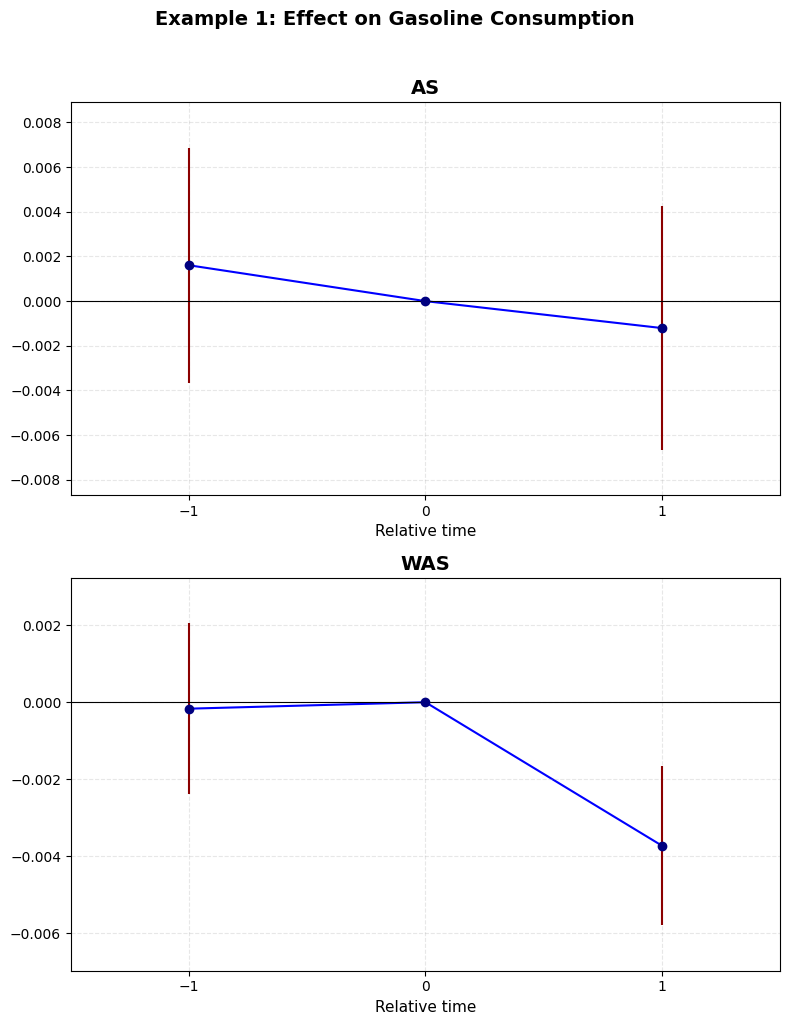

In [22]:
fig1 = plot_did_event_study(result1, title='Example 1: Effect on Gasoline Consumption')
plt.show()

In [23]:
print('='*70)
print('  EXAMPLE 2: Effect of tax on gasoline price')
print('='*70)

result2 = did_multiplegt_stat(
    df=df, Y='lngpinc', ID='id', Time='year', D='tau',
    estimator=['aoss', 'waoss'],
    estimation_method='dr',
    order=2,
    noextrapolation=True,
    placebo=True,
    aoss_vs_waoss=True,
)
print('\n✔ Estimation completed')

  EXAMPLE 2: Effect of tax on gasoline price

✔ Estimation completed


In [24]:
summary_did_multiplegt_stat(result2)


-----------------------------------
N                =             1603
WAOSS Method     =    Doubly Robust
Polynomial Order =                2
Common Support   = No Extrapolation
-----------------------------------

----------------------------------------------------------------------
                    Estimation of AOSS(s)
----------------------------------------------------------------------
       Estimate         SE       LB CI      UB CI Switchers Stayers
AOSS  0.0006545  0.0023858  -0.0040216  0.0053306       355   1,248

----------------------------------------------------------------------
               Estimation of AOSS(s) - Placebo
----------------------------------------------------------------------
       Estimate         SE       LB CI      UB CI Switchers Stayers
AOSS  0.0002000  0.0047499  -0.0091098  0.0095098       170     881

----------------------------------------------------------------------
                    Estimation of WAOSS(s)
---------------------

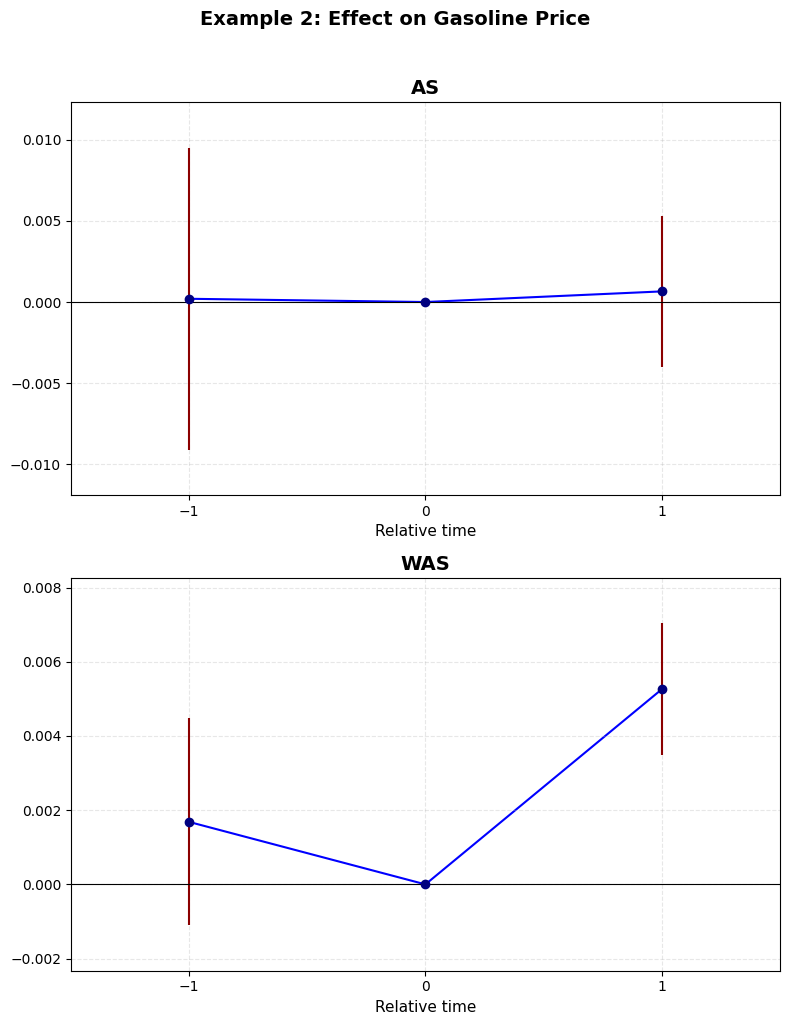

In [25]:
fig2 = plot_did_event_study(result2, title='Example 2: Effect on Gasoline Price')
plt.show()

In [26]:
print('='*70)
print('  EXAMPLE 3: IV-WAS (Price Elasticity)')
print('='*70)

# To obtain the First Stage (WAS) and the IV-WAS, we need to run both
# The First Stage is the effect of Z (tau) on D (lngpinc)
# This is equivalent to Example 2, but we include it here for the plot

result3 = did_multiplegt_stat(
    df=df, Y='lngca', ID='id', Time='year', D='lngpinc', Z='tau',
    estimator=['ivwaoss'],
    estimation_method='ra',
    order=2,
    noextrapolation=True,
    placebo=True,
)

# First Stage: effect of tau on lngpinc (saved for the plot)
result3_first_stage = did_multiplegt_stat(
    df=df, Y='lngpinc', ID='id', Time='year', D='tau',
    estimator=['waoss'],
    estimation_method='dr',
    order=2,
    noextrapolation=True,
    placebo=True,
)

print('\n✔ Estimation completed')
print('\nFirst Stage (effect of tau on lngpinc):')
if result3_first_stage:
    fs_table = result3_first_stage.get('results', {}).get('table')
    if fs_table is not None:
        print(f"  WAS = {fs_table.loc['WAOSS', 'Estimate']:.7f}")

  EXAMPLE 3: IV-WAS (Price Elasticity)
Without exact_match, estimation_method() is ignored (Stata behavior). Using 'dr'.

✔ Estimation completed

First Stage (effect of tau on lngpinc):
  WAS = 0.0052603


In [27]:
summary_did_multiplegt_stat(result3_first_stage)  # First Stage (WAS)
summary_did_multiplegt_stat(result3)               # IV-WAS


-----------------------------------
N                =             1603
WAOSS Method     =    Doubly Robust
Polynomial Order =                2
Common Support   = No Extrapolation
-----------------------------------

----------------------------------------------------------------------
                    Estimation of WAOSS(s)
----------------------------------------------------------------------
        Estimate         SE      LB CI      UB CI Switchers Stayers
WAOSS  0.0052603  0.0009087  0.0034791  0.0070414       355   1,248

----------------------------------------------------------------------
               Estimation of WAOSS(s) - Placebo
----------------------------------------------------------------------
        Estimate         SE       LB CI      UB CI Switchers Stayers
WAOSS  0.0016841  0.0014232  -0.0011053  0.0044735       170     881

-----------------------------------
N                =             1603
IVWAOSS Method   =    Doubly Robust
Polynomial Order =     

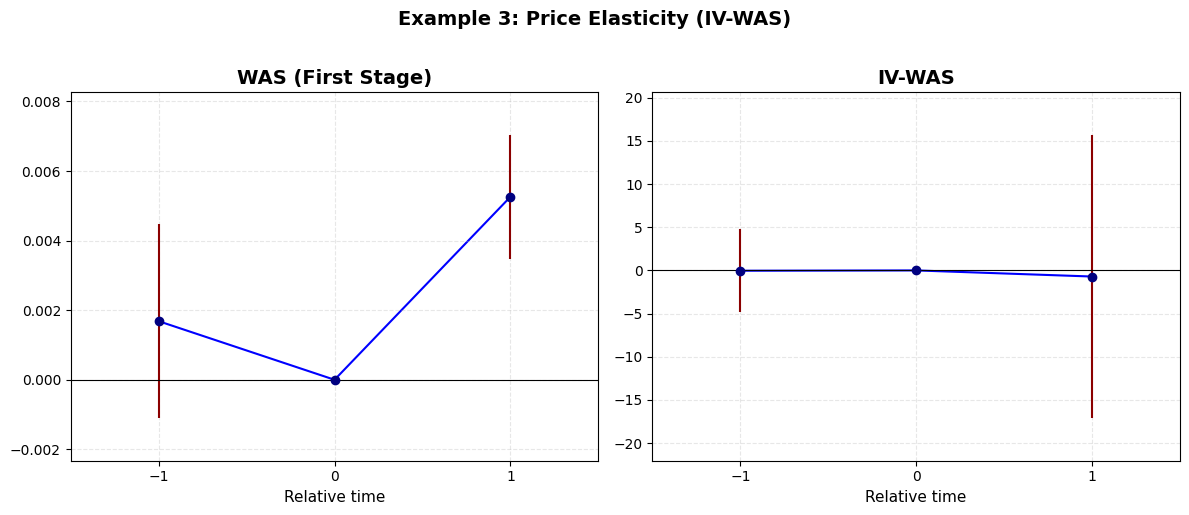

In [28]:
# Plot with First Stage (from result3_first_stage) and IV-WAS (from result3)
def plot_iv_combined(result_iv, result_fs, title=None, figsize=(12, 5)):
    '''
    Combines First Stage from one result and IV-WAS from another.
    '''
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    def plot_single(ax, result, est_key, est_name):
        if result is None:
            ax.text(0.5, 0.5, f'{est_name}\nnot available', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(est_name, fontsize=14, fontweight='bold')
            return
        
        table = result.get('results', {}).get('table')
        table_placebo = result.get('results', {}).get('table_placebo')
        
        if table is None:
            ax.text(0.5, 0.5, f'{est_name}\nno data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(est_name, fontsize=14, fontweight='bold')
            return
        
        main_row = None
        for idx in table.index:
            if str(idx).upper() == est_key.upper():
                main_row = table.loc[idx]
                break
        
        if main_row is None:
            ax.text(0.5, 0.5, f'{est_name}\nnot found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(est_name, fontsize=14, fontweight='bold')
            return
        
        pe_main = float(main_row['Estimate']) if 'Estimate' in main_row.index else float(main_row.iloc[0])
        lb_main = float(main_row['LB CI']) if 'LB CI' in main_row.index else np.nan
        ub_main = float(main_row['UB CI']) if 'UB CI' in main_row.index else np.nan
        
        pe_placebo, lb_placebo, ub_placebo = np.nan, np.nan, np.nan
        if table_placebo is not None:
            for idx in table_placebo.index:
                if str(idx).upper() == est_key.upper():
                    placebo_row = table_placebo.loc[idx]
                    pe_placebo = float(placebo_row['Estimate']) if 'Estimate' in placebo_row.index else float(placebo_row.iloc[0])
                    lb_placebo = float(placebo_row['LB CI']) if 'LB CI' in placebo_row.index else np.nan
                    ub_placebo = float(placebo_row['UB CI']) if 'UB CI' in placebo_row.index else np.nan
                    break
        
        x_vals, y_vals, lb_vals, ub_vals = [], [], [], []
        if not np.isnan(pe_placebo):
            x_vals.append(-1)
            y_vals.append(pe_placebo)
            lb_vals.append(lb_placebo)
            ub_vals.append(ub_placebo)
        
        x_vals.extend([0, 1])
        y_vals.extend([0.0, pe_main])
        lb_vals.extend([0.0, lb_main])
        ub_vals.extend([0.0, ub_main])
        
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        lb_vals = np.array(lb_vals)
        ub_vals = np.array(ub_vals)
        
        yerr = np.vstack([y_vals - lb_vals, ub_vals - y_vals])
        
        ax.plot(x_vals, y_vals, 'b-', linewidth=1.5, zorder=1)
        ax.errorbar(x_vals, y_vals, yerr=yerr, fmt='o', color='navy',
                   markersize=6, capsize=0, ecolor='darkred', elinewidth=1.5, zorder=2)
        ax.axhline(y=0, color='black', linewidth=0.8)
        ax.set_xlim(-1.5, 1.5)
        ax.set_xticks([-1, 0, 1])
        ax.set_xlabel('Relative time', fontsize=11)
        ax.set_title(est_name, fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Calculate Y limits based on actual data
        all_vals = list(y_vals) + list(lb_vals) + list(ub_vals)
        valid_vals = [v for v in all_vals if np.isfinite(v)]
        if valid_vals:
            y_min = min(valid_vals)
            y_max = max(valid_vals)
            y_range = y_max - y_min
            if y_range < 1e-6:  # Very small range
                y_margin = max(abs(y_max), abs(y_min)) * 0.5 + 0.001
            else:
                y_margin = y_range * 0.15
            ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    # Plot First Stage (WAOSS from result_fs)
    plot_single(axes[0], result_fs, 'WAOSS', 'WAS (First Stage)')
    
    # Plot IV-WAS (IVWAOSS from result_iv)
    plot_single(axes[1], result_iv, 'IVWAOSS', 'IV-WAS')
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig
fig3 = plot_iv_combined(result3, result3_first_stage, title='Example 3: Price Elasticity (IV-WAS)')
plt.show()